In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from src.functions import get_sents
from sklearn.decomposition import TruncatedSVD
import matplotlib.pylab as plt
%matplotlib inline

See https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
for explanation of next cell:

In [2]:
%load_ext autoreload
%autoreload 2
#%autoreload?

In [3]:
raw_data_path = './data/raw/ted-talks/'
meta_data_filename = 'ted_main.csv'
transcripts_filename = 'transcripts.csv'
m_df = pd.read_csv(raw_data_path+meta_data_filename)
print('m_df:',m_df.shape)
t_df = pd.read_csv(raw_data_path+transcripts_filename)
print('t_df:',t_df.shape)

m_df: (2550, 17)
t_df: (2467, 2)


The dataframe t_df has all the transcripts.  I'll first break out the talks that contain the word love.

In [4]:
love=t_df[t_df['transcript'].str.contains('love',case=False)]
love.shape

(1175, 2)

The first talk that contains the word love:

In [5]:
love.iloc[0,0]

'Good morning. How are you?(Laughter)It\'s been great, hasn\'t it? I\'ve been blown away by the whole thing. In fact, I\'m leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we\'ve had and in all of the people here. Just the variety of it and the range of it. The second is that it\'s put us in a place where we have no idea what\'s going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don\'t you? I find this very interesting. If you\'re at a dinner party, and you say you work in education — Actually, you\'re not often at dinner parties, frankly.(Laughter)If you work in education, you\'re not asked.(Laughter)And you\'re never asked back, curiously. That\'s strange to me. But if you are, and you say to somebody, you

I was getting an error message that googling suggested the following line of code would cure:  It appears that it only had to be run once on my machine to provide the functionality it delivers.

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/sean/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Ok, I'm going to want the sentence that contains the word and some context so I'd be able to tell what the author is talking about.

In [7]:
# Tokenize into sentences
df=pd.DataFrame(sent_tokenize(love.iloc[0,0]))
# Find only those sentences that contain the word love
df2=df[df[0].str.contains('love',case=False)]
# Get from 2 sentences before to 2 sentences after
df.iloc[df2.iloc[0].name-2:df2.iloc[0].name+2][0].str.cat(sep=' ')


'(Laughter)Well, I was born... no. (Laughter)I heard a great story recently — I love telling it — of a little girl who was in a drawing lesson. She was six, and she was at the back, drawing, and the teacher said this girl hardly ever paid attention, and in this drawing lesson, she did.'

Now I'll generalize that to find all the context snippets containing the word love.  I've placed this function into the file src/functions.py.

In [8]:
love_snippets = get_sents(love,'love')
print(love_snippets.shape)
love_snippets.columns

(1175, 4)


Index(['transcript', 'url', 'n_love_sents', 'love'], dtype='object')

In [76]:
love_snippets.n_love_sents.value_counts()
#Note value are not in order within value_counts

1.0     512
2.0     260
3.0     145
4.0     101
5.0      55
6.0      32
7.0      16
8.0      10
13.0      9
10.0      6
12.0      5
14.0      4
9.0       4
11.0      3
17.0      2
19.0      2
15.0      2
26.0      1
45.0      1
47.0      1
18.0      1
16.0      1
29.0      1
46.0      1
Name: n_love_sents, dtype: int64

In [12]:
love_snippets[love_snippets.n_love_sents==46]

,transcript,url,n_love_sents,love
2276,"OK, so today I want to talk about how we talk ...",https://www.ted.com/talks/mandy_len_catron_a_b...,46.0,"OK, so today I want to talk about how we talk ..."


In [13]:
# love_snippets.loc[2276].love

Let's do topic modeling for 

In [14]:
cv1 = CountVectorizer(stop_words='english')
doc_word = cv1.fit_transform(love_snippets.love)
doc_word.shape

(1175, 14962)

In [95]:
for i in range(2,6):
    lsa = TruncatedSVD(i)
    doc_topic = lsa.fit_transform(doc_word)
    print(int(i),'topics variance ratios:',lsa.explained_variance_ratio_)

2 topics variance ratios: [0.29669144 0.04290357]
3 topics variance ratios: [0.29669144 0.04290356 0.03730232]
4 topics variance ratios: [0.29669144 0.04290356 0.0373023  0.02290845]
5 topics variance ratios: [0.29669144 0.04290356 0.03730229 0.02290837 0.02405696]


In [16]:
doc_topic.shape

(1175, 2)

In [17]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [18]:
display_topics(lsa, cv1.get_feature_names(), 10)


Topic  0
love, people, like, just, think, know, romantic, really, laughter, ve

Topic  1
come, wait, road, lies, free, ll, tennessee, way, hard, low


In [19]:
doc_topic[:5,:]

array([[ 3.73194552,  1.0369024 ],
       [ 1.45559308, -0.04730465],
       [ 1.26322018,  0.07874928],
       [ 3.23350219,  0.49365931],
       [20.66597454, -0.61019544]])

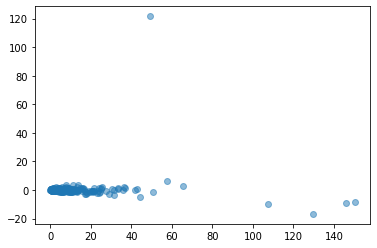

In [81]:
plt.scatter(doc_topic[:,0],doc_topic[:,1], alpha = 0.5);
# plt.axis([0, 140, 0, 10])

There doesn't really seem to be a great collection of clusters in that 2D space!  However, some of the points are showing to be "outliers".  Let's look into them.

In [82]:
df = pd.DataFrame(doc_topic)
df.head()

,0,1
0,3.731946,1.036902
1,1.455593,-0.047305
2,1.263220,0.078749
3,3.233502,0.493659
4,20.665975,-0.610195


These are the rows of the doc_topic array that are "interesting"...

In [84]:
df.iloc[:,1].idxmax()   # index of the single high y "outlier":

1134

In [85]:
df[df.iloc[:,0]>100]   # indices of 4 high x "outliers":

,0,1
16,129.666019,-16.704544
116,146.072159,-9.394992
918,107.438569,-9.788808
1073,150.289949,-8.556906


Change ind below to each of the "interesting" indices above to see the text scored.

In [87]:
ind=918
print(love_snippets.iloc[ind].n_love_sents)
love_snippets.iloc[ind].love

29.0


'I published this article in the New York Times Modern Love column in January of this year. "To Fall in Love With Anyone, Do This." I published this article in the New York Times Modern Love column in January of this year. "To Fall in Love With Anyone, Do This." And the article is about a psychological study designed to create romantic love in the laboratory, and my own experience trying the study myself one night last summer.So the procedure is fairly simple: two strangers take turns asking each other 36 increasingly personal questions and then they stare into each other\'s eyes without speaking for four minutes.So here are a couple of sample questions.Number 12: If you could wake up tomorrow having gained any one quality or ability, what would it be?Number 28: When did you last cry in front of another person? I published this article in the New York Times Modern Love column in January of this year. "To Fall in Love With Anyone, Do This." And the article is about a psychological study

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [97]:
tfidf1 = TfidfVectorizer(stop_words='english')
doc_words_tfidf1 = tfidf1.fit_transform(love_snippets.love)
doc_words_tfidf1.shape

(1175, 14962)

In [105]:
tfidf_lsa=[]
tfidf_doc_topic=[]
for i in range(2,7):
    tfidf_lsa.append(TruncatedSVD(i))
    tfidf_doc_topic.append(tfidf_lsa[i-2].fit_transform(doc_words_tfidf1))
    print(int(i),'topics variance ratios:',tfidf_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.00422015 0.00367817]
3 topics variance ratios: [0.00422016 0.00368508 0.00319206]
4 topics variance ratios: [0.00422015 0.00365609 0.00320658 0.00311998]
5 topics variance ratios: [0.00422015 0.00367702 0.00321791 0.00313935 0.00287249]
6 topics variance ratios: [0.00422015 0.00369491 0.00322919 0.00317268 0.00287903 0.00278493]


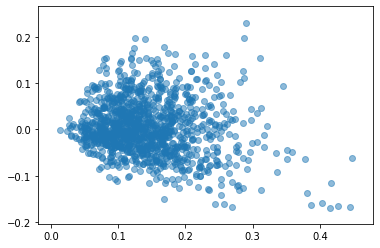

In [106]:
plt.scatter(tfidf_doc_topic[0][:,0],tfidf_doc_topic[0][:,1], alpha = 0.5);

In [127]:
from sklearn.cluster import KMeans

In [135]:
num_clusters = 2
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(tfidf_doc_topic[4])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=10, tol=0.0001, verbose=0)

In [136]:
km.labels_

array([1, 1, 1, ..., 1, 0, 1], dtype=int32)

In [124]:
from sklearn.manifold import TSNE

In [126]:
model = TSNE(n_components=2, random_state=0,verbose=1)
low_data = model.fit_transform(tfidf_doc_topic[4])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1175 samples in 0.001s...
[t-SNE] Computed neighbors for 1175 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1175
[t-SNE] Computed conditional probabilities for sample 1175 / 1175
[t-SNE] Mean sigma: 0.035224
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.788933
[t-SNE] KL divergence after 1000 iterations: 1.500977


In [123]:
len(low_data)

1175

ValueError: 'c' argument has 7044 elements, which is not acceptable for use with 'x' with size 1175, 'y' with size 1175.

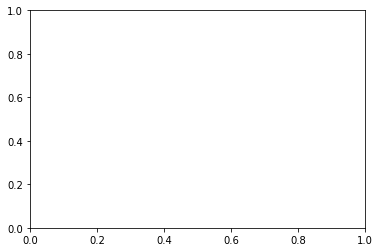

In [121]:
target = km.labels_
#target_names = digits.target_names

colors = cycle(['r','g','b','c','m','y','orange','k','aqua','yellow'])
target_ids = range(len(target_names))
plt.figure(dpi=150)
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(low_data[target == i, 0], low_data[target == i, 1], c=c, label=label, s=15, alpha=1)
plt.legend(fontsize=10, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
plt.xlim(-100,100);
plt.title("Digit Clusters with TSNE", fontsize=12)
plt.ylabel("Junk TSNE Axis 2", fontsize=12)
plt.xlabel("Junk TSNE Axis 1", fontsize=12);
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);